In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score
)

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf


In [23]:
df_train = pd.read_csv(r"C:\Users\Habiba Elkashef\Documents\PythonProjects\ML_models\Dataset\train.csv")
df_test  = pd.read_csv(r"C:\Users\Habiba Elkashef\Documents\PythonProjects\ML_models\Dataset\test.csv")

print(df_train.shape, df_test.shape)

(345056, 54) (86264, 54)


In [24]:
# Features
X = df_train.drop(columns=["label", "label_encoded"]).values
X_test = df_test.drop(columns=["label", "label_encoded"]).values

# Encoded labels (training)
y = df_train["label_encoded"].values
y_test_encoded = df_test["label_encoded"].values

# Original labels (for reporting)
y_labels = df_train["label"].values
y_test_labels = df_test["label"].values

num_features = X.shape[1]
num_classes = df_train["label_encoded"].nunique()

In [25]:
label_mapping = (
    df_train[["label_encoded", "label"]]
    .drop_duplicates()
    .sort_values("label_encoded")
    .set_index("label_encoded")["label"]
    .to_dict()
)

class_names = list(label_mapping.values())

print(label_mapping)

{0: 'Benign', 1: 'DNS', 2: 'LDAP', 3: 'MSSQL', 4: 'NTP', 5: 'NetBIOS', 6: 'Portmap', 7: 'SNMP', 8: 'Syn', 9: 'TFTP', 10: 'UDP', 11: 'UDPLag'}


In [26]:
def focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        pt = tf.reduce_sum(y_true * y_pred, axis=1)
        return -tf.reduce_mean(
            tf.pow(1.0 - pt, gamma) * tf.math.log(pt + 1e-8)
        )
    return loss

In [27]:
def build_cvae_classifier(input_dim, latent_dim, num_classes):
    inputs = Input(shape=(input_dim,))

    # --------------------
    # Encoder
    # --------------------
    x = Dense(256, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, activation="relu")(x)
    x = BatchNormalization()(x)

    # Latent space
    z = Dense(latent_dim, activation="relu", name="latent")(x)

    # --------------------
    # Classifier Head
    # --------------------
    x_cls = Dense(64, activation="relu")(z)
    x_cls = BatchNormalization()(x_cls)
    x_cls = Dropout(0.3)(x_cls)

    outputs = Dense(num_classes, activation="softmax")(x_cls)

    model = Model(inputs, outputs)
    return model


In [29]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np

# Compute class weights (ONCE)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)

class_weights = tf.constant(class_weights, dtype=tf.float32)

# =========================
# Weighted Focal Loss
# =========================
def weighted_focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        # y_true: (batch,)
        y_true_int = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true_int, depth=num_classes)

        # Probability of the true class
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=1)

        # Get class weights
        weights = tf.gather(class_weights, y_true_int)

        # Focal loss
        loss_val = weights * tf.pow(1.0 - pt, gamma) * (-tf.math.log(pt + 1e-8))
        return tf.reduce_mean(loss_val)

    return loss


In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

BEST_CVAE_MODEL_PATH = "best_cvae_model.h5"

best_f1 = -1
cv_f1_scores = []
fold = 1

for train_idx, val_idx in skf.split(X, y):
    print(f"\n========== Fold {fold} ==========")

    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    model = build_cvae_classifier(
        input_dim=num_features,
        latent_dim=64,  
        num_classes=num_classes
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=weighted_focal_loss(gamma=2.0),
        metrics=["accuracy"]
    )

    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=6,          
                restore_best_weights=True
            )
        ],
        verbose=1
    )

    # Validation predictions
    y_val_probs = model.predict(X_val, verbose=0)
    y_val_pred_encoded = np.argmax(y_val_probs, axis=1)

    # Macro F1 (THIS IS WHAT YOU WANT)
    f1 = f1_score(
        y_val,
        y_val_pred_encoded,
        average="macro",
        zero_division=0
    )

    cv_f1_scores.append(f1)
    print(f"Fold {fold} MACRO F1-score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        model.save(BEST_CVAE_MODEL_PATH)
        print("Best CVAE model saved")

    fold += 1

print("\nMean CV MACRO F1-score:", np.mean(cv_f1_scores))


========== Fold 1 ==========
Epoch 1/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4975 - loss: 1.3657 - val_accuracy: 0.4184 - val_loss: 1.3354
Epoch 2/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6127 - loss: 1.0437 - val_accuracy: 0.4643 - val_loss: 1.1824
Epoch 3/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7006 - loss: 0.8819 - val_accuracy: 0.5516 - val_loss: 1.1609
Epoch 4/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7272 - loss: 0.8202 - val_accuracy: 0.6793 - val_loss: 1.1400
Epoch 5/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7477 - loss: 0.7819 - val_accuracy: 0.6301 - val_loss: 1.2302
Epoch 6/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7647 - loss: 0.7414 - val_accuracy: 0.7130 - val_loss: 1.0708
Epoch 7/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7631 - loss: 0.7296 - val_accuracy: 0.6344 - val_loss: 1.2888
Epoch 8/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 14s

Fold 1 MACRO F1-score: 0.5263
Best CVAE model saved

========== Fold 2 ==========
Epoch 1/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.5267 - loss: 1.3445 - val_accuracy: 0.5301 - val_loss: 1.5000
Epoch 2/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.6231 - loss: 1.0272 - val_accuracy: 0.6332 - val_loss: 1.2697
Epoch 3/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.6748 - loss: 0.9139 - val_accuracy: 0.5979 - val_loss: 1.2926
Epoch 4/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7092 - loss: 0.8272 - val_accuracy: 0.6220 - val_loss: 1.2964
Epoch 5/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7277 - loss: 0.8011 - val_accuracy: 0.6128 - val_loss: 1.1653
Epoch 6/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7492 - loss: 0.7513 - val_accuracy: 0.7827 - val_loss: 1.1450
Epoch 7/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7535 - loss: 0.7302 - val_accuracy: 0.6403 - val_loss: 

Fold 4 MACRO F1-score: 0.5544
Best CVAE model saved

========== Fold 5 ==========
Epoch 1/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.5159 - loss: 1.4055 - val_accuracy: 0.6215 - val_loss: 1.3118
Epoch 2/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6211 - loss: 1.0175 - val_accuracy: 0.6125 - val_loss: 1.2651
Epoch 3/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6745 - loss: 0.8915 - val_accuracy: 0.5771 - val_loss: 1.1644
Epoch 4/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7077 - loss: 0.8235 - val_accuracy: 0.5872 - val_loss: 1.1354
Epoch 5/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7343 - loss: 0.7768 - val_accuracy: 0.6210 - val_loss: 1.2982
Epoch 6/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7465 - loss: 0.7502 - val_accuracy: 0.4659 - val_loss: 1.4381
Epoch 7/100
4314/4314 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7596 - loss: 0.7298 - val_accuracy: 0.5667 - val_loss: 1

In [32]:
best_cvae_model = load_model(
    BEST_CVAE_MODEL_PATH,
    custom_objects={
        "loss": weighted_focal_loss(gamma=2.0)
    }
)


y_test_probs = best_cvae_model.predict(X_test)
y_test_pred_encoded = np.argmax(y_test_probs, axis=1)

y_test_pred_labels = (
    pd.Series(y_test_pred_encoded)
    .map(label_mapping)
    .values
)

print("CVAE – Test Classification Report")
print(
    classification_report(
        y_test_labels,
        y_test_pred_labels,
        digits=4
    )
)

print("Test Accuracy:", accuracy_score(y_test_labels, y_test_pred_labels))

2696/2696 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
CVAE – Test Classification Report
              precision    recall  f1-score   support

      Benign     0.9042    0.9213    0.9127     19566
         DNS     0.1322    0.0218    0.0374       734
        LDAP     0.4596    0.4081    0.4323       669
       MSSQL     0.7359    0.6176    0.6716      2947
         NTP     0.8985    0.9823    0.9385     24274
     NetBIOS     0.2681    0.2540    0.2609       248
     Portmap     0.0241    0.0292    0.0264       137
        SNMP     0.3146    0.5672    0.4047       543
         Syn     0.9660    0.5633    0.7117      9875
        TFTP     0.9549    0.9895    0.9719     19783
         UDP     0.9204    0.8678    0.8933      5702
      UDPLag     0.3372    0.6769    0.4502      1786

    accuracy                         0.8770     86264
   macro avg     0.5763    0.5749    0.5593     86264
weighted avg     0.8879    0.8770    0.8738     86264

Test Accuracy: 0.8769591022906427


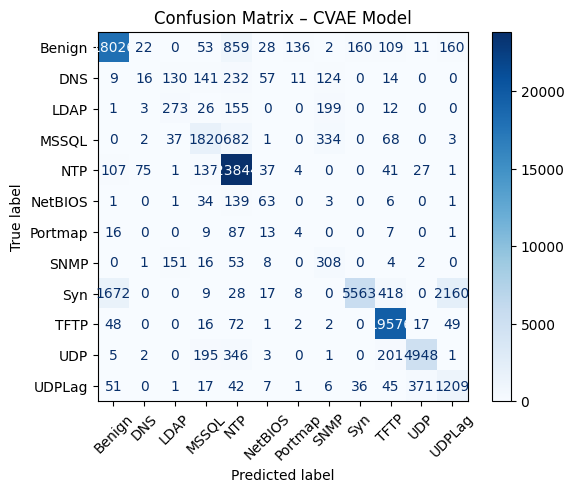

In [33]:
cm = confusion_matrix(
    y_test_labels,
    y_test_pred_labels,
    labels=class_names
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    values_format="d"
)

plt.title("Confusion Matrix – CVAE Model")
plt.show()

In [36]:
def predict_and_save_cvae(
    df,
    model_path,
    label_mapping,
    output_csv,
    label_col="label",
    label_encoded_col="label_encoded"
):
    model = load_model(
    BEST_CVAE_MODEL_PATH,
    custom_objects={
        "loss": weighted_focal_loss(gamma=2.0)
    }
)

    df_out = df.copy()

    X = df.drop(columns=[label_col, label_encoded_col]).values
    y_true = df[label_col].values

    y_probs = model.predict(X, verbose=0)
    y_pred_encoded = np.argmax(y_probs, axis=1)

    y_pred_labels = (
        pd.Series(y_pred_encoded)
        .map(label_mapping)
        .values
    )

    df_out["true_label"] = y_true
    df_out["predicted_label"] = y_pred_labels

    print("\nCVAE – TEST Classification Report")
    print(
        classification_report(
            y_true,
            y_pred_labels,
            digits=4
        )
    )

    df_out.to_csv(output_csv, index=False)
    print(f"Predictions saved to: {output_csv}")

    return df_out

In [37]:
df_cvae_predictions = predict_and_save_cvae(
    df=df_test,
    model_path=BEST_CVAE_MODEL_PATH,
    label_mapping=label_mapping,
    output_csv="cvae_test_predictions.csv"
)


CVAE – TEST Classification Report
              precision    recall  f1-score   support

      Benign     0.9042    0.9213    0.9127     19566
         DNS     0.1322    0.0218    0.0374       734
        LDAP     0.4596    0.4081    0.4323       669
       MSSQL     0.7359    0.6176    0.6716      2947
         NTP     0.8985    0.9823    0.9385     24274
     NetBIOS     0.2681    0.2540    0.2609       248
     Portmap     0.0241    0.0292    0.0264       137
        SNMP     0.3146    0.5672    0.4047       543
         Syn     0.9660    0.5633    0.7117      9875
        TFTP     0.9549    0.9895    0.9719     19783
         UDP     0.9204    0.8678    0.8933      5702
      UDPLag     0.3372    0.6769    0.4502      1786

    accuracy                         0.8770     86264
   macro avg     0.5763    0.5749    0.5593     86264
weighted avg     0.8879    0.8770    0.8738     86264

Predictions saved to: cvae_test_predictions.csv
